In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
#extracting the zipped folders from kaggle
# /kaggle/input/dogs-vs-cats-redux-kernels-edition
import zipfile
train_path = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
test_path = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
file_path = '/kaggle/working'

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(file_path)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(file_path)

In [3]:
import os

image_dir = '/kaggle/working/train'

#extracting the names from filename and saving it in new col named label
filenames = os.listdir(image_dir)
labels = [x.split('.')[0] for x in filenames]
data = pd.DataFrame({'filename': filenames, 'label': labels})

#display data
data.head()

,filename,label
0,dog.12344.jpg,dog
1,cat.7189.jpg,cat
2,dog.11021.jpg,dog
3,cat.7304.jpg,cat
4,cat.7345.jpg,cat


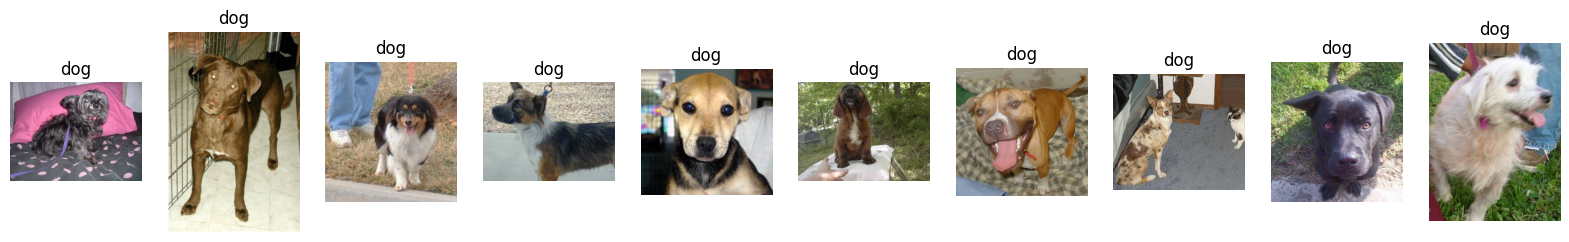

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as imread

#displaying the sample image from dogs train dataset of images
plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    filename = 'train/dog.'+str(i)+'.jpg'
    image = plt.imread(filename)
    plt.imshow(image)
    plt.title('dog')
    plt.axis('off')

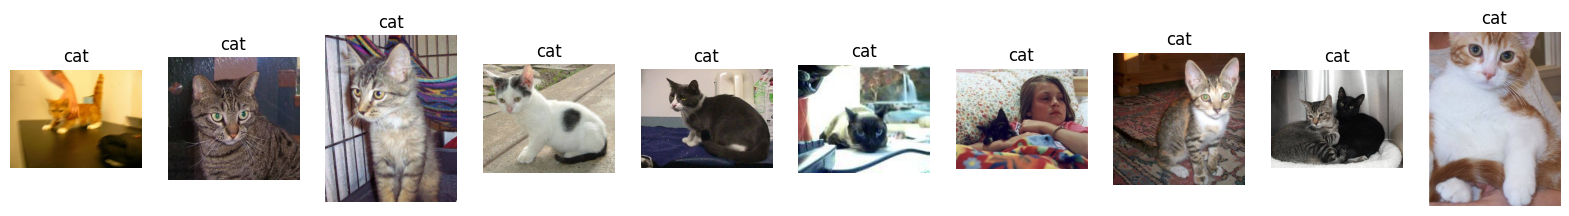

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as imread

#displaying the sample image from cats train dataset of images
plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    filename = 'train/cat.'+str(i)+'.jpg'
    image = plt.imread(filename)
    plt.imshow(image)
    plt.title('cat')
    plt.axis('off')

In [6]:
# creating Train Test split
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(data, stratify = data.label, random_state= 42)

In [7]:
image_size = 128  #sets height & weight of the image
bat_size = 32 #batch size
channel = 3

In [8]:
# Importing the utilities for data augmentation and efficient loading of images
#ImageDataGenerator is iterator select batch of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
            rotation_range = 15, #angle degree how much can be rotation made
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            zoom_range = 0.2,
            channel_shift_range = 0.2,
            fill_mode = 'nearest',
            horizontal_flip = True,
            rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1./255)

2025-10-04 16:10:17.606169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759594217.840624      72 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759594217.909766      72 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = 'train/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = 'train/',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Dense
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,channel))) 
model.add(BatchNormalization()) #reduction
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2)) #dropping 20% data

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu')) #(3,3) filter 3x3, batch size 128, 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #compresses
model.add(Dropout(0.2)) #
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-04 16:10:34.262279: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,514 (19.50 MB)

 Trainable params: 5,110,530 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,
    factor = 0.5,
    min_lr = 0.0001,
    verbose = 1
)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = 'True', verbose = 0)

In [12]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [13]:
cat_dog = model.fit(train_generator, validation_data = val_generator, 
                    callbacks = [early_stopping, learning_rate_reduction],
                    epochs = 5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - accuracy: 0.6015 - loss: 0.7675 - val_accuracy: 0.6078 - val_loss: 0.8056 - learning_rate: 0.0010
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 704s 1s/step - accuracy: 0.6956 - loss: 0.5873 - val_accuracy: 0.7586 - val_loss: 0.5067 - learning_rate: 0.0010
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.7421 - loss: 0.5185 - val_accuracy: 0.5829 - val_loss: 0.9962 - learning_rate: 0.0010
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - accuracy: 0.7837 - loss: 0.4538 - val_accuracy: 0.7782 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - accuracy: 0.8201 - loss: 0.3952 - val_accuracy: 0.7237 - val_loss: 0.5903 - learning_rate: 0.0010


In [14]:
cat_dog.history


{'accuracy': [0.6365866661071777,
  0.7087466716766357,
  0.7538666725158691,
  0.7891200184822083,
  0.8203200101852417],
 'loss': [0.6820490956306458,
  0.5687698125839233,
  0.5066354274749756,
  0.44841817021369934,
  0.3937481641769409],
 'val_accuracy': [0.6078400015830994,
  0.7585600018501282,
  0.5828800201416016,
  0.7782400250434875,
  0.7236800193786621],
 'val_loss': [0.8056110739707947,
  0.5067183375358582,
  0.9961661100387573,
  0.49362629652023315,
  0.5903272032737732],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513]}

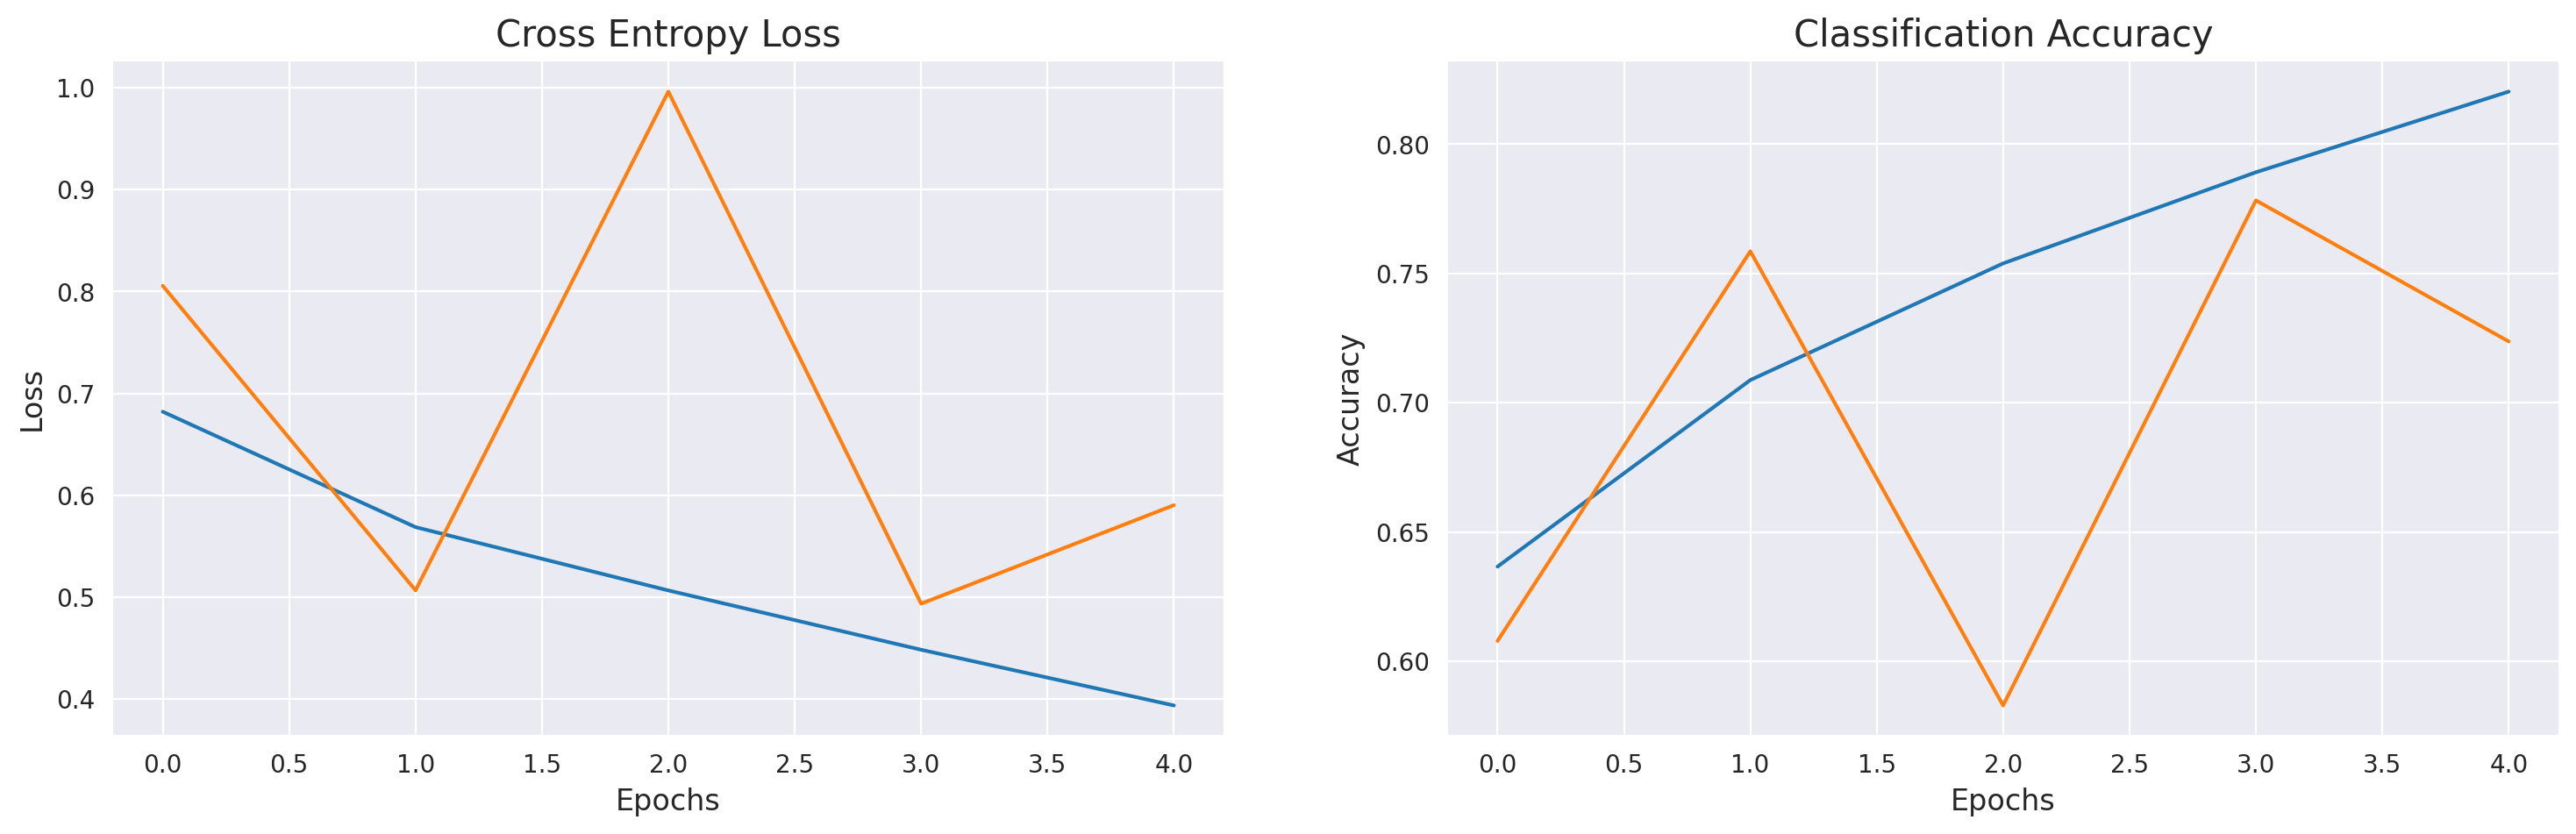

In [15]:
import seaborn as sns
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [16]:
# Image generator (only rescaling, no augmentation for test)
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = "/kaggle/working/test"
filenames = os.listdir(test_dir)

# Flow from directory (no labels since it's test data)
test_data = pd.DataFrame({"filename":filenames})
test_data['label'] = 'unknown'

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory = "test/",         # parent dir
    x_col = "filename",
    y_col = "label",       # only the test folder
    target_size=(image_size, image_size),      # use same size as training
    batch_size=bat_size,
    class_mode=None,             # no labels
    shuffle=False                # IMPORTANT to keep order
)

Found 12500 validated image filenames.


In [17]:
test_predict = model.predict(test_generator,verbose = 0)
test_predict_argmax = np.argmax(test_predict, axis=1)
y_test_pred = test_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [18]:
test_data.head()

,filename,label
0,4280.jpg,cat
1,6643.jpg,cat
2,5479.jpg,dog
3,4142.jpg,dog
4,2965.jpg,cat


In [19]:
# csv file output for submission


op = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv',index_col='id')

op['label'] = y_test_pred

op.to_csv('submission.csv',index=True)